# ECE 157A/272A Fall 2024 Homework 2

Name: Edward Ding

In [113]:
%pip install joblib==1.3.2 matplotlib==3.7.1 numpy==1.23.5 pandas==1.5.3 plotly==5.15.0 scikit-learn==1.2.2 seaborn==0.13.1 "nbformat>=4.2.0" scikit-image

Note: you may need to restart the kernel to use updated packages.


In [114]:
import os
import typing
from typing import Tuple

import numpy as np
import pandas as pd

# OpenCV and Scikit-Image for image manipulation
from skimage.transform import resize
from skimage.measure import label, regionprops, perimeter

# Seaborn and Matplotlib for plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-Learn Descision Tree and helper functions
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, homogeneity_score, completeness_score

FAIL = 2 # failing die
PASS = 1 # passing die
NO_DIE = 0 # no die
RANDOM_SEED = 10

### Helper Functions

In [115]:
# TODO: Implement a function that takes a wafer map and outputs it to a directory with the given name
def output_image(wafer_map: np.ndarray, name: str, dir: str, vmin: int=0, vmax: int=2) -> None:
    # use os library to check whether directory exists

    # if not, make the directory
    if not os.path.exists(dir):
        os.makedirs(dir)

    # use plt.imsave to save wafer_map under the given directory with the given name
    # note: set the min value (vmin) and max vlaue (vmax) for plt.imsave based on wafer map value range
    image_path = os.path.join(dir, f"{name}.png")

    plt.imsave(image_path, wafer_map, cmap='viridis', vmin=vmin, vmax=vmax)



# TODO: Implement a function that outputs all wafer maps to corresponding failure type directories
def output_all_wafer_maps(df: pd.DataFrame) -> None:
    # iterate through all rows in the dataframe with df.iterrows()
    # CODE HERE
        # From the row, get wafer map, failure type, lot name and wafer index
        # output wafer map as "<failure type dir>/<lot name>-<wafer index>.png"
        # CODE HERE
    for _, row in df.iterrows():
        wafer_map = row['waferMap']
        failure_type = row['failureType']
        lot_name = row['lotName']
        wafer_index = row['waferIndex']
        
        # Create the directory path based on failure type
        dir_path = os.path.join("wafer_maps", failure_type)
        
        # Name the output file as "<lot name>-<wafer index>.png"
        file_name = f"{lot_name}-{wafer_index}"
        
        # Call the output_image function to save the wafer map
        output_image(wafer_map, file_name, dir_path)


In [116]:
# TODO: Implement a function that generates a single plot showing one wafer map example from each failure type
def visualize_failure_types(df: pd.DataFrame, figsize: Tuple[int, int] = (16, 9), index_off: int = 0) -> None:
    # Find unique failure types within the "failureType" column of the df
    failure_types = df['failureType'].unique()
    
    # Create a plt canvas with 2 rows and 3 columns (6 subplots)
    fig, axes = plt.subplots(2, 3, figsize=figsize)

    # Flatten axes for easier indexing
    axes = axes.flatten()

    # Iterate through all failure types and show one wafer map per class
    for i, failure_type in enumerate(failure_types):
        # Pick the first image from the current failure type
        wafer_data = df[df['failureType'] == failure_type].iloc[index_off]['waferMap']
        
        # Display the wafer map in the subplot using the correct axis method
        axes[i].imshow(wafer_data, cmap='viridis', vmin=0, vmax=2)
        
        # Set the title to the failure type
        axes[i].set_title(failure_type)
        
        # Turn off the axes grid lines and ticks
        axes[i].axis('off')
    
    # Hide any remaining empty subplots if we have fewer than 6 failure types
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    # Show the plot
    plt.show()

### Load Dataset

In [117]:
# load training dataset as pandas dataframe
np_train = np.load('./data/wafermap_train.npy', allow_pickle=True)
df_train = pd.DataFrame.from_records(np_train)


### Inspect Dataset

In [118]:
# use pandas to inspect the dataset information
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2746 entries, 0 to 2745
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dieSize         2746 non-null   float64
 1   failureType     2746 non-null   object 
 2   lotName         2746 non-null   object 
 3   trainTestLabel  2746 non-null   object 
 4   waferIndex      2746 non-null   float64
 5   waferMap        2746 non-null   object 
dtypes: float64(2), object(4)
memory usage: 128.8+ KB


In [119]:
# inspect the dieSize
# notice that the die size varies? 
# We will need to preprocess them to make it uniform 
df_train['dieSize'].value_counts()

1334.0    300
1226.0    191
1801.0    177
1080.0    176
2393.0    129
         ... 
1153.0      1
3858.0      1
6547.0      1
1668.0      1
2470.0      1
Name: dieSize, Length: 255, dtype: int64

<Axes: >

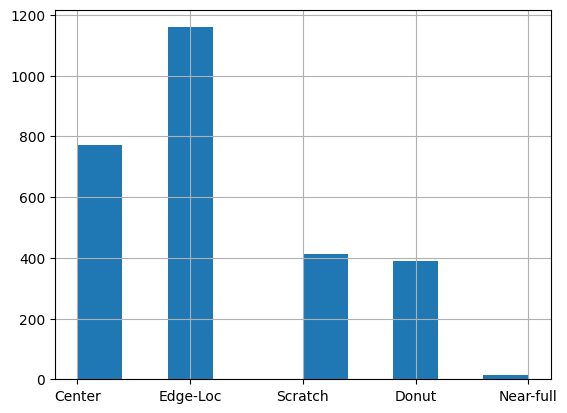

In [120]:
# inspect the failure types and the distributions
df_train['failureType'].hist()

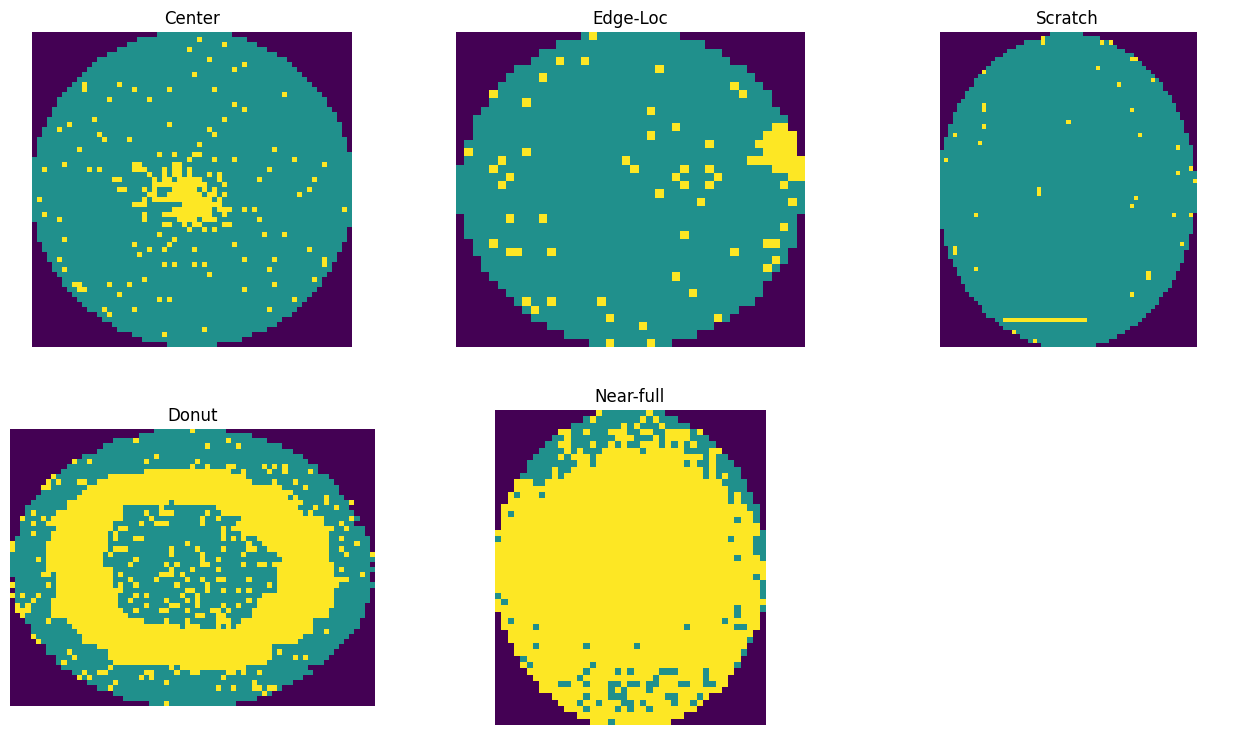

In [121]:
# show a wafermap in each class
visualize_failure_types(df_train)

In [122]:
# output all images to failure type directory
root_dir = 'defect_types'
output_all_wafer_maps(df_train)

### Data Preparation (Part 1)

For data preparation, we need to perform the following operations:
1) Resize the wafer maps as a numpy array of shape [x, 64, 64]
2) Convert the labels into numeric values

In [123]:
# Create dictionary for converting string to numeric number
string2int = {
    'Center': 0,
    'Edge-Loc': 1,
    'Scratch': 2,
    'Donut': 3,
    'Near-full': 4
}
# TODO: The function takes the failure type string 
# and returns the numeric value of failureType
# Make use of your dictionary from the line above.
def convert_failure_type(failure_type: str) -> int:
    return string2int.get(failure_type, -1)  # Returns -1 if the failure type is not found

# TODO: The function resizes a wafer to specified output shape using opencv's resize function
def resize_wafer_map(wafer_map: np.ndarray, output_shape: tuple=(64, 64)) -> np.ndarray:
    resized_wafer = resize(wafer_map, output_shape, anti_aliasing=True, preserve_range=True)
    return resized_wafer.astype(np.uint8)  # Ensure the output is in uint8 format

# create dataframe columns to store the return values of the two tasks below:
#       (1) reshapes the wafer maps as a numpy array of shape (64, 64), 
#       (2) and converts the failureType into numeric values 
def prepare_data(df: pd.DataFrame, has_labels: bool=True) -> Tuple[np.ndarray, list]:
    # Resize_wafer_map function to resize the wafer map to a larger size
    # note: here we decided to overwrite the waferMap column, but for best
    # practice, it's best to create a new column unless you don't need the original
    # wafer map data anymore
    # plt.imshow(df['waferMap'])
    df['waferMap'] = df['waferMap'].apply(resize_wafer_map) 
    # plt.imshow(df['waferMap'])
    if(has_labels):
        df['failureTypeInt'] = df['failureType'].apply(convert_failure_type)

    return df

Prepare the data with the above function

In [124]:
# actually resizing the wafer map and converting failure types
# in the training dataframe
df_train = prepare_data(df_train)

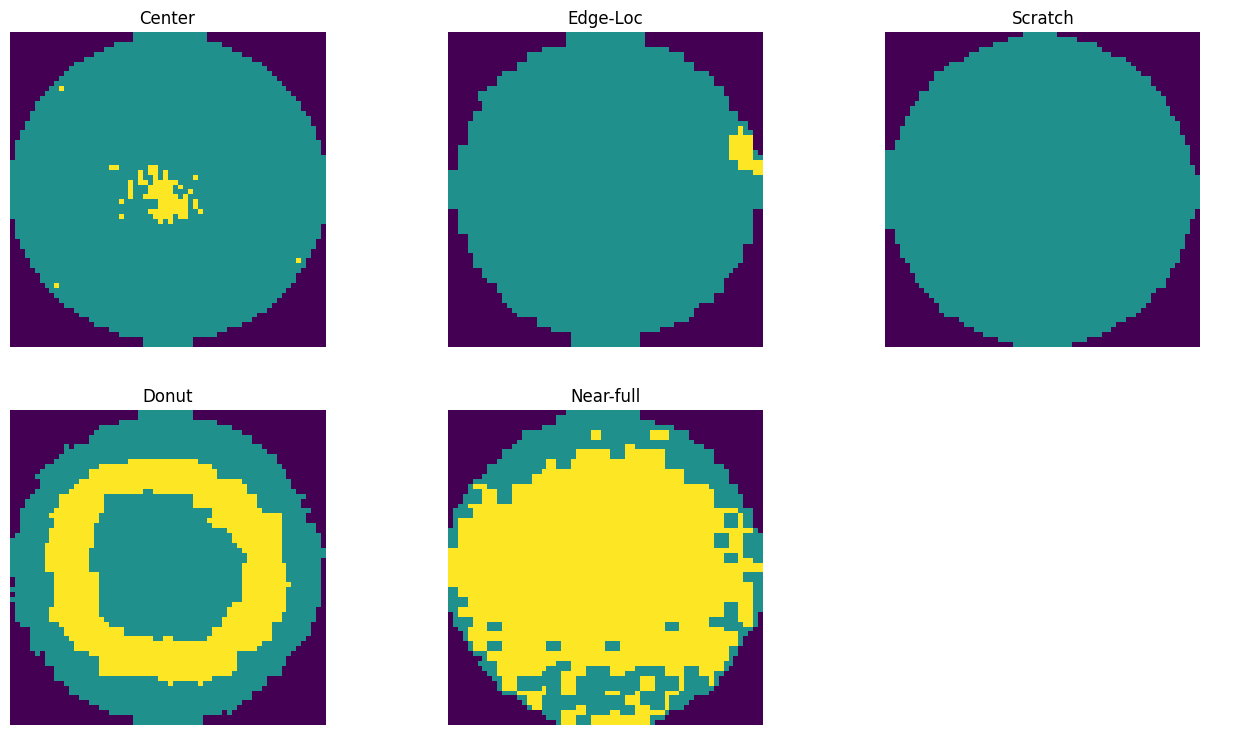

In [125]:
visualize_failure_types(df_train)

### Feature Engineering
Extract features from the wafer maps

In [126]:
# The function that detects connect components using skimage
# and selects one with the largest area which we call salient region
# TODO: skip to the create_feature_columns code block and generate salient region
# before proceeding to other feature extractor functions
# https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
# https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops
def get_salient_region(row: pd.Series) -> np.ndarray:
    # get wafer map from dataframe row
    wafer_map = row['waferMap']

    # create a wafer map with NO_DIE as background and FAIL as defect
    failure_only = np.zeros_like(wafer_map)
    failure_only[wafer_map==FAIL] = FAIL

    # label the connected components and get their regions properties
    # note: you might want to plot the labeled_image to take a look at the 
    # return of the label function
    labeled_image = label(failure_only, background=NO_DIE, connectivity=2)
    region_props = regionprops(labeled_image)



    # Check if there are any regions; if not, return an empty salient region
    if not region_props:
        return np.zeros_like(wafer_map)  # or return None if preferable

    # returns the largest connected component as salient region
    # note: label image starts connected component label at value 1 with background being 0
    # thus, we need to add 1 after argmax
    largest_region_label = np.argmax([prop.area for prop in region_props]) + 1
    salient_region = np.zeros_like(labeled_image)
    salient_region[labeled_image == largest_region_label] = FAIL

    # # uncomment to verify the salient region
    # fig, ax = plt.subplots(nrows=1, ncols=2)
    # ax[0].imshow(wafer_map)
    # ax[1].imshow(salient_region)
    # plt.show()

    return salient_region

# TODO: The function returns the ratio of the area of the salient region to the area of the wafer map
def get_area_ratio(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    wafer_map = row['waferMap']
    salient_region = get_salient_region(row)

    # count the number of fail dice on salient region
    
    salient_region_area = np.sum(salient_region == FAIL)

    # count the total number of dice on wafer map

    total_area = np.sum(wafer_map != NO_DIE)

    # divide them to get area_ratio
    area_ratio = salient_region_area / total_area if total_area > 0 else 0
    
    return area_ratio

# TODO: The function returns the ratio of the perimeter of the salient region to the radius of the wafer map
def get_perimeter_ratio(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    wafer_map = row['waferMap']
    salient_region = get_salient_region(row)

    # label the salient region connected components and get their regions properties
    salient_perimeter = perimeter(salient_region == FAIL)

    # find perimeter and wafer map radius
    wafer_radius = max(wafer_map.shape) / 2

    perimeter_ratio = salient_perimeter / wafer_radius if wafer_radius > 0 else 0

    return perimeter_ratio

# TODO: The function returns the maximal distance between the salient region and 
# the center of the wafer map
def get_max_dist_from_center(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    wafer_map = row['waferMap']
    salient_region = get_salient_region(row)

    # find center of the wafer map
    center_y, center_x = np.array(wafer_map.shape) // 2
    salient_coords = np.column_stack(np.nonzero(salient_region == FAIL))

    # get all coordinates of the salient region and compute the max distance
    # from center
    if len(salient_coords) == 0:
        return 0  # No salient region
    
    # Compute Euclidean distances from the center to each point in the salient region
    distances = np.sqrt((salient_coords[:, 0] - center_y) ** 2 + (salient_coords[:, 1] - center_x) ** 2)
    
    # Return the maximum distance
    return np.max(distances)

# TODO: The function returns the minimal distance between the salient region and 
# the center of the wafer map
def get_min_dist_from_center(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    wafer_map = row['waferMap']
    salient_region = get_salient_region(row)

    # find center of the wafer map
    center_y, center_x = np.array(wafer_map.shape) // 2

    salient_coords = np.column_stack(np.nonzero(salient_region == FAIL))
    
    if len(salient_coords) == 0:
        return 0  # No salient region
    
    distances = np.sqrt((salient_coords[:, 0] - center_y) ** 2 + (salient_coords[:, 1] - center_x) ** 2)
    
    # Return the minimum distance
    return np.min(distances)

# TODO: The function returns the ratio of the length of the major axis of the estimated 
# ellipse surrounding the salient region to the radius of the wafer map
def get_major_axis_ratio(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row

    salient_region = get_salient_region(row)

    # label the salient region connected components and get their regions properties

    region_props = regionprops(label(salient_region==FAIL))

    # find major axis and wafer map radius

    if len(region_props) > 0: 
        major_axis_length = region_props[0].major_axis_length
        wafer_radius = max(row['waferMap'].shape) / 2
        return major_axis_length / wafer_radius if wafer_radius > 0 else 0


    return 0

# TODO: The function returns the ratio of the length of the minor axis of the estimated 
# ellipse surrounding the salient region to the radius of the wafer map
def get_minor_axis_ratio(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row

    salient_region = get_salient_region(row)

    # label the salient region connected components and get their regions properties
    region_props = regionprops(label(salient_region==FAIL))

    # find minor axis and wafer map radius

    if len(region_props) > 0:
        minor_axis_length = region_props[0].minor_axis_length
        wafer_radius = max(row['waferMap'].shape)/2
        return minor_axis_length / wafer_radius if wafer_radius > 0 else 0 

    return 0


#TODO: The function returns the solidity, indicating the proportion of defective dice
# in the estimated convex hull of the salient region
def get_solidity(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    salient_region = get_salient_region(row)

    # label the salient region connected components and get their regions properties
    region_props = regionprops(label(salient_region==FAIL))

    # get solidity of salient region
    if len(region_props) > 0:
        return region_props[0].solidity

    return 0

# TODO: The function returns the eccentricity of the salient region
def get_eccentricity(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row

    salient_region = get_salient_region(row)

    # label the salient region connected components and get their regions properties

    region_props = regionprops(label(salient_region==FAIL))


    # get eccentricity of salient region

    if len(region_props) >0: 
        return region_props[0].eccentricity

    return 0

# TODO: The function returns the ratio of the failed dice on the wafer map to the total 
# number of dice on the wafer map
def get_yield_loss(row: pd.Series) -> float:
    # retrieve wafer map
    wafer_map = row['waferMap']
    
    # count FAIL dice and total number of dice
    total_dice = np.sum(wafer_map != NO_DIE)
    fail_dice = np.sum(wafer_map == FAIL)

    # compute yield loss

    return fail_dice / total_dice if total_dice > 0 else 0


# TODO: The function returns the ratio of the failed dice on the outermost two rings of the 
# wafer map to the total number of dice on the outermost two rings of the wafer map
def get_edge_yield_loss(row: pd.Series) -> float:
    # retrieve wafer map

    wafer_map = row['waferMap']

    # find ring label that highlights the outermost two rings of the wafer
    ring_mask = ring_label_from_outside(wafer_map)

    # get edge FAIL dice and total number of edge dice

    edge_dice = wafer_map[ring_mask > 0]

    total_edge_dice = np.sum(edge_dice != NO_DIE)
    fail_edge_dice = np.sum(edge_dice == FAIL)

    return fail_edge_dice / total_edge_dice if total_edge_dice > 0 else 0


# TODO: This helper function returns return an numpy array highlighting the outermost two rings
# of the wafer map with nonzero value
def ring_label_from_outside(wafer_map: np.ndarray) -> np.ndarray:
    center = np.array(wafer_map.shape)//2
    y,x = np.indices(wafer_map.shape)
    distance_from_center = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)

    # define the mask for the othermost two rings

    max_distance = np.max(distance_from_center)
    ring_mask = (distance_from_center > max_distance -2)

    return ring_mask.astype(int)



[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
0.020227560050568902
7.211102550927978
0.0
1.3428300858899105
0.4097988508847298
0.2500520394218446
0.6881720430107527
0.7922609793257968
0.024968394437420986
0


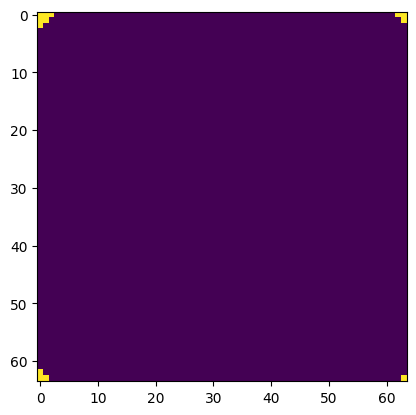

In [127]:
# # uncomment to use test codes for feature extractor functions
failure_type = 'Center'
row_index = 0
row = df_train.loc[df_train['failureType']==failure_type].iloc[row_index]


print(get_salient_region(row))
print(get_area_ratio(row))
print(get_max_dist_from_center(row))
print(get_min_dist_from_center(row))
print(get_perimeter_ratio(row))
print(get_major_axis_ratio(row))
print(get_minor_axis_ratio(row))
print(get_solidity(row))
print(get_eccentricity(row))
print(get_yield_loss(row))
print(get_edge_yield_loss(row))

plt.imshow(ring_label_from_outside(row['waferMap']))


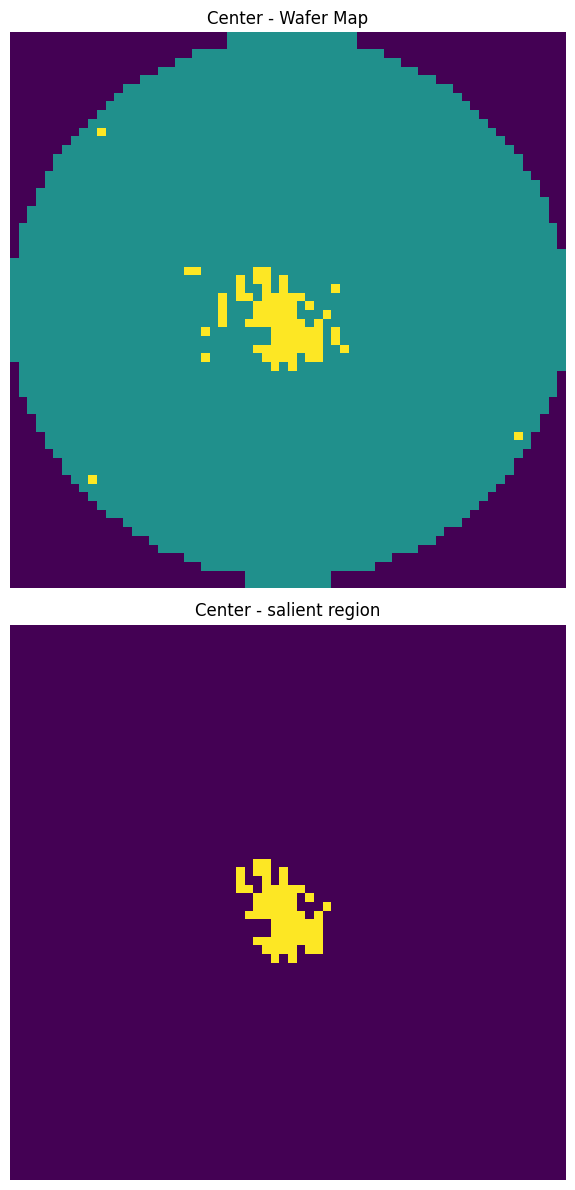

feature value for Center
area ratio: 0.0202
perimenter ratio: 1.3428
max distance from center: 7.2111
min distance from center: 0.0000
Major axis ratio: 0.4098
minor axis ratio: 0.2501
solidity: 0.6882
eccentricty: 0.7923
yield loss0.0250
edge yield loss: 0.0000


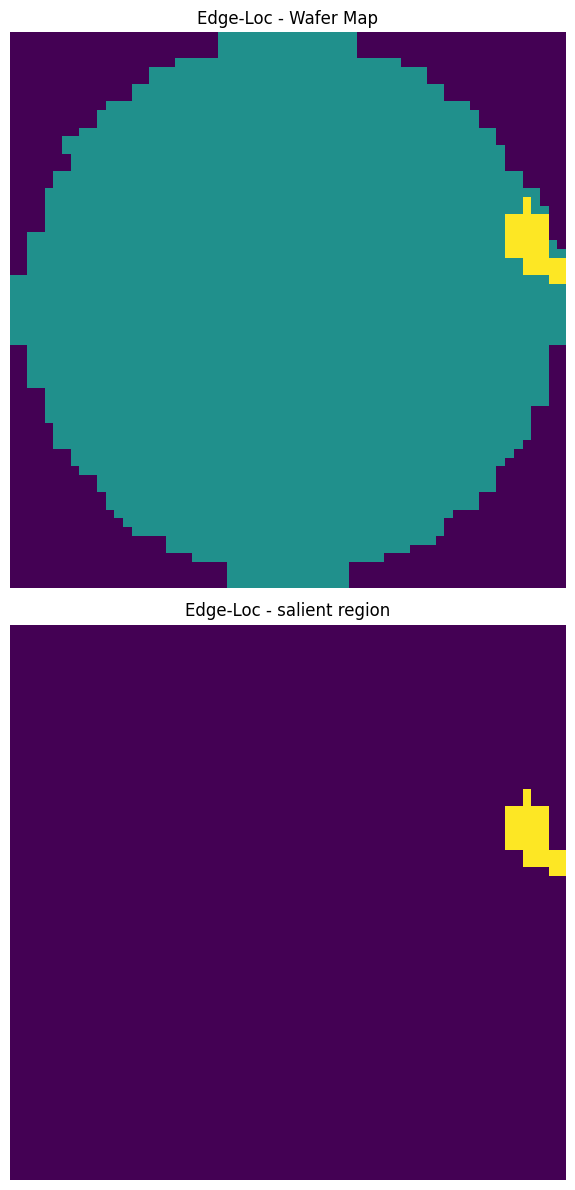

feature value for Edge-Loc
area ratio: 0.0128
perimenter ratio: 0.7835
max distance from center: 31.5753
min distance from center: 25.9615
Major axis ratio: 0.3209
minor axis ratio: 0.1702
solidity: 0.8298
eccentricty: 0.8478
yield loss0.0128
edge yield loss: 0.0000


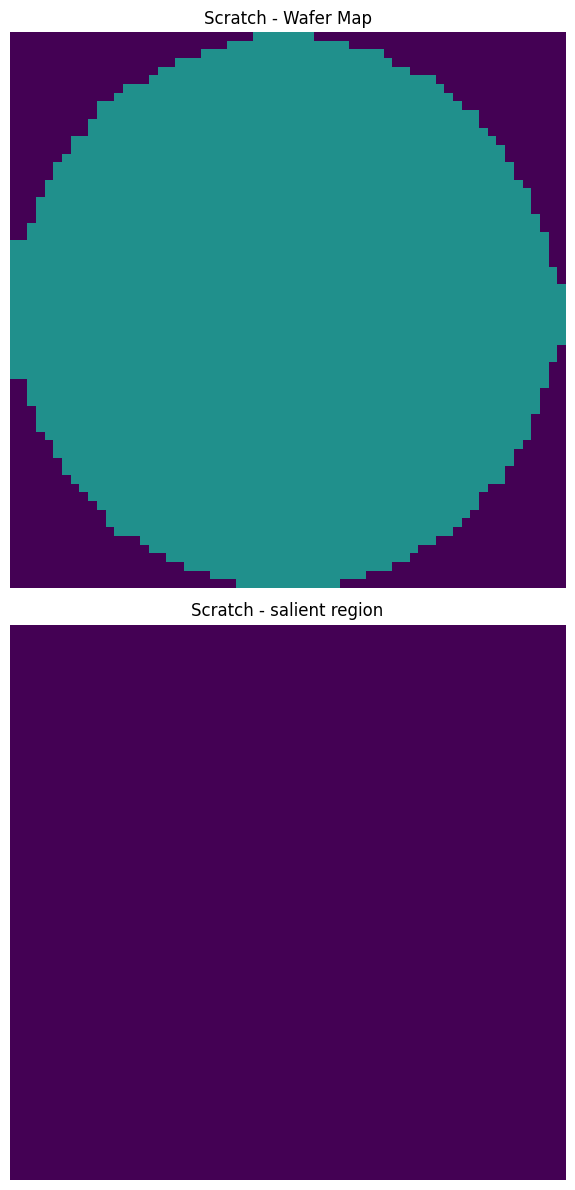

feature value for Scratch
area ratio: 0.0000
perimenter ratio: 0.0000
max distance from center: 0.0000
min distance from center: 0.0000
Major axis ratio: 0.0000
minor axis ratio: 0.0000
solidity: 0.0000
eccentricty: 0.0000
yield loss0.0000
edge yield loss: 0.0000


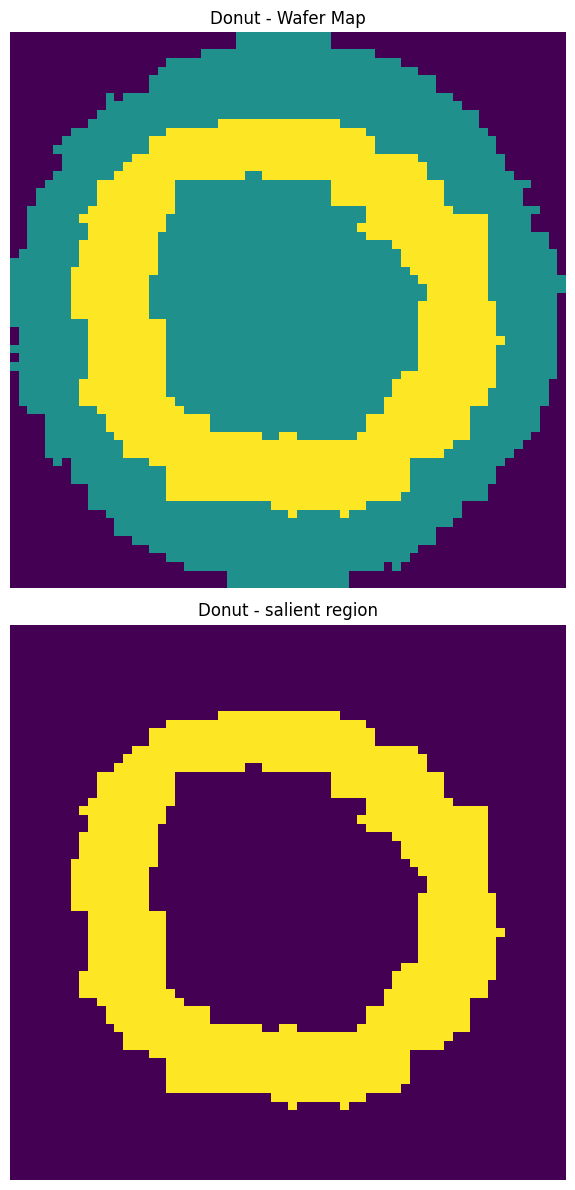

feature value for Donut
area ratio: 0.3320
perimenter ratio: 8.9503
max distance from center: 26.6271
min distance from center: 12.7279
Major axis ratio: 1.8680
minor axis ratio: 1.6997
solidity: 0.5443
eccentricty: 0.4148
yield loss0.3320
edge yield loss: 0.0000


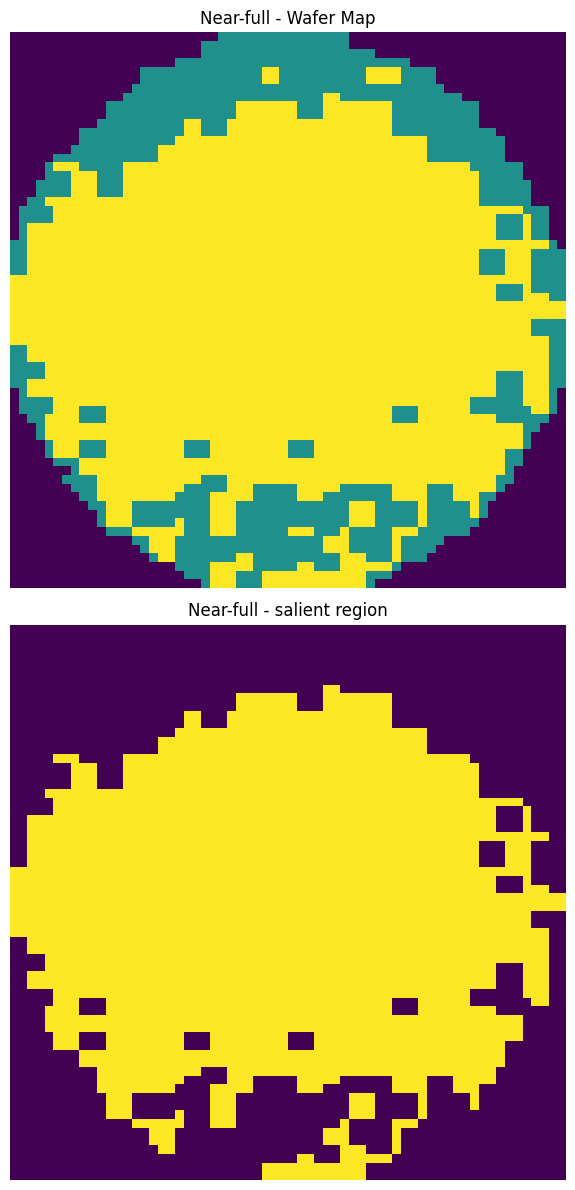

feature value for Near-full
area ratio: 0.7077
perimenter ratio: 12.8610
max distance from center: 32.2490
min distance from center: 0.0000
Major axis ratio: 1.9321
minor axis ratio: 1.5775
solidity: 0.8123
eccentricty: 0.5774
yield loss0.7164
edge yield loss: 0.0000


In [128]:
failure_types = df_train['failureType'].unique()

for failure_type in failure_types:
    row = df_train[df_train['failureType'] == failure_type].iloc[0]
    wafer_map = row['waferMap']
    
    row ['salientRegion'] = get_salient_region(row)
    salient_region = row['salientRegion']

    area_ratio = get_area_ratio(row) 
    perimeter_ratio = get_perimeter_ratio(row)
    max_dist_from_center = get_max_dist_from_center(row)
    min_dist_from_center = get_min_dist_from_center(row) 
    major_axis_ratio = get_major_axis_ratio(row)
    minor_axis_ratio = get_minor_axis_ratio(row)
    solidity = get_solidity(row)
    eccentricty = get_eccentricity(row)
    yield_loss = get_yield_loss(row)
    edge_yield_loss = get_edge_yield_loss(row)

    fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(6,12))

    axes[0].imshow(wafer_map,vmin=0,vmax=2)
    axes[0].set_title(f"{failure_type} - Wafer Map")
    axes[0].axis('off')

    axes[1].imshow(salient_region, vmin=0, vmax=2)
    axes[1].set_title(f"{failure_type} - salient region")
    axes[1].axis("off")


    plt.tight_layout()
    plt.show()

    print(f"feature value for {failure_type}")
    print(f'area ratio: {area_ratio:.4f}')
    print(f'perimenter ratio: {perimeter_ratio:.4f}')
    print(f"max distance from center: {max_dist_from_center:.4f}")
    print(f"min distance from center: {min_dist_from_center:.4f}")
    print(f'Major axis ratio: {major_axis_ratio:.4f}')
    print(f"minor axis ratio: {minor_axis_ratio:.4f}")
    print(f"solidity: {solidity:.4f}")
    print(f"eccentricty: {eccentricty:.4f}")
    print(f"yield loss{yield_loss:.4f}")
    print(f"edge yield loss: {edge_yield_loss:.4f}")
    

In [129]:
# This function applies all feature extractor functions onto the 
# dataframe and save the results to new columns
def create_feature_columns(df: pd.DataFrame) -> pd.DataFrame:
    df['salientRegion'] = df.apply(get_salient_region, axis=1)
    # TODO: fill in the rest of the feature extractor functions using same format
    df['areaRatio'] = df.apply(get_area_ratio, axis=1)
    df['perimeterRatio'] = df.apply(get_perimeter_ratio, axis=1)
    df['maxDistFromCenter'] = df.apply(get_max_dist_from_center, axis=1)
    df['minDistFromCenter'] = df.apply(get_min_dist_from_center, axis=1)
    df['majorAxisRatio'] = df.apply(get_major_axis_ratio, axis=1)
    df['minorAxisRatio'] = df.apply(get_minor_axis_ratio, axis=1)
    df['solidity'] = df.apply(get_solidity, axis=1)
    df['eccentricity'] = df.apply(get_eccentricity, axis=1)
    df['yieldLoss'] = df.apply(get_yield_loss, axis=1)
    df['edgeYieldLoss'] = df.apply(get_edge_yield_loss, axis=1)
    df.info()
    # Return the updated dataframe df at the end.
    return df

In [130]:
# actually applying the feature extractors on the training dataframe
df_train = create_feature_columns(df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2746 entries, 0 to 2745
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dieSize            2746 non-null   float64
 1   failureType        2746 non-null   object 
 2   lotName            2746 non-null   object 
 3   trainTestLabel     2746 non-null   object 
 4   waferIndex         2746 non-null   float64
 5   waferMap           2746 non-null   object 
 6   failureTypeInt     2746 non-null   int64  
 7   salientRegion      2746 non-null   object 
 8   areaRatio          2746 non-null   float64
 9   perimeterRatio     2746 non-null   float64
 10  maxDistFromCenter  2746 non-null   float64
 11  minDistFromCenter  2746 non-null   float64
 12  majorAxisRatio     2746 non-null   float64
 13  minorAxisRatio     2746 non-null   float64
 14  solidity           2746 non-null   float64
 15  eccentricity       2746 non-null   float64
 16  yieldLoss          2746 

### Data Preparation (Part 2)

prepare the dataset for training models

In [131]:
# TODO: From the dataframe select the features we extracted as X 
# and y is the numerical failure type labels

selected_features = df_train.columns[-10:]

X = df_train[selected_features]
df_train.info()

y = df_train['failureTypeInt']  


# TODO: split dataset into training and validation set
# we will set aside some portion of the training data as validation data
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,  test_size=0.2, random_state=RANDOM_SEED

)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2746 entries, 0 to 2745
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dieSize            2746 non-null   float64
 1   failureType        2746 non-null   object 
 2   lotName            2746 non-null   object 
 3   trainTestLabel     2746 non-null   object 
 4   waferIndex         2746 non-null   float64
 5   waferMap           2746 non-null   object 
 6   failureTypeInt     2746 non-null   int64  
 7   salientRegion      2746 non-null   object 
 8   areaRatio          2746 non-null   float64
 9   perimeterRatio     2746 non-null   float64
 10  maxDistFromCenter  2746 non-null   float64
 11  minDistFromCenter  2746 non-null   float64
 12  majorAxisRatio     2746 non-null   float64
 13  minorAxisRatio     2746 non-null   float64
 14  solidity           2746 non-null   float64
 15  eccentricity       2746 non-null   float64
 16  yieldLoss          2746 

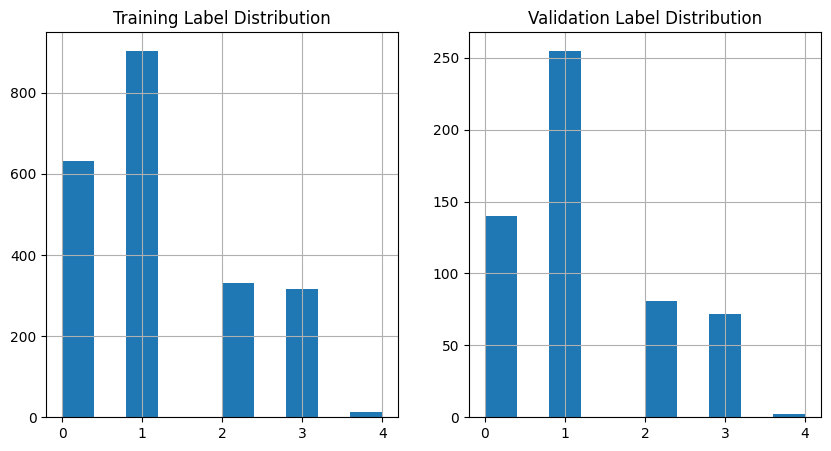

In [132]:
# check train/validation distribution
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
y_train.hist()
plt.title('Training Label Distribution')

plt.subplot(1,2,2)
y_valid.hist()
plt.title('Validation Label Distribution')

plt.show()

Train and Evaluate a Decision Tree Model

In [133]:
# TODO: initialize Decision Tree classifier with max tree depth of 3
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


# TODO: Train the Decision Tree classifier with the training data
dt_classifier = DecisionTreeClassifier(max_depth=4, random_state=RANDOM_SEED)
dt_classifier.fit(X_train, y_train)



DecisionTreeClassifier(max_depth=4, random_state=10)

In [134]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

# TODO: Initialize Support Vector Classifier
svc_classifier = SVC(kernel='linear', random_state=RANDOM_SEED)

# TODO: Train the Support Vector Classifier with the training data
svc_classifier.fit(X_train, y_train)


SVC(kernel='linear', random_state=10)

In [135]:
# TODO: Make a dictionary that is the reverse of the string2int mapping
# defined above. You can do this by hand, or for added challenge figure
# out how to do it programmatically so that the two remain in sync.
int2String = {
    0: 'Center',
    1: 'Edge-Loc',
    2: 'Scratch',
    3: 'Donut',
    4: 'Near-full'
}

from sklearn.metrics import accuracy_score

# TODO: Implement a function that calculates the prediction accuracy.
def calculate_accuracy(pred_labels: np.ndarray, true_labels: np.ndarray):
    return accuracy_score(true_labels, pred_labels)

# TODO: Implement a function that calculates the prediction accuracy for each failure type separately.
def calculate_per_class_accuracy(pred_labels: np.ndarray, true_labels: np.ndarray):
    unique_labels = np.unique(true_labels)
    per_class_accuracy = {}

    # Calculate accuracy for each class
    for label in unique_labels:
        mask = true_labels == label
        class_accuracy = np.sum(pred_labels[mask] == true_labels[mask]) / np.sum(mask)
        per_class_accuracy[int2String[label]] = class_accuracy
    
    return per_class_accuracy



Model accuracy on training data set is 91.62%
Model accuracy on training data set for each class is {'Center': 0.9239302694136292, 'Edge-Loc': 0.9612831858407079, 'Scratch': 0.8614457831325302, 'Donut': 0.8322784810126582, 'Near-full': 0.8461538461538461}


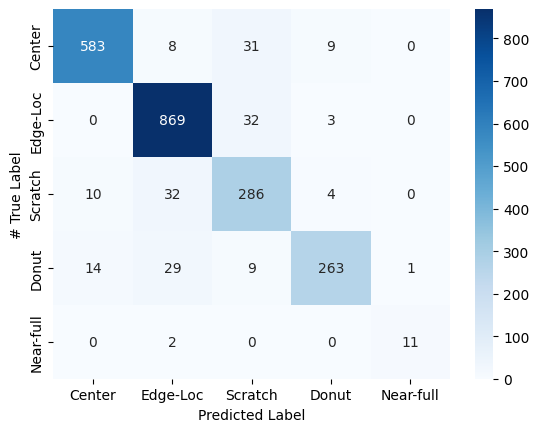

In [136]:
# TODO: get the predicted labels of the training data and calculate the accuracy
pred_train = (
    dt_classifier.predict(X_train)
)
acc_train = (
calculate_accuracy(pred_train, y_train)
)
acc_train=acc_train*100
print(f'Model accuracy on training data set is {acc_train:.2f}%')

# TODO: calculate the accuracy for each failure type
accuracies_train = (
calculate_per_class_accuracy(pred_train, y_train))
print(f'Model accuracy on training data set for each class is {accuracies_train}')

# TODO: get failure types string sorted by their numerical value
# that is, the strings like 'Center' and 'Scratch' sorted by the ints
# assigned to them.
tick_labels = [
    int2String[i] for i in sorted(int2String.keys())]

# TODO: compute the confusion matrix
cm = (
    confusion_matrix(y_train, pred_train)
)

# plot confusion matrix using heatmap
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=tick_labels , 
            yticklabels=tick_labels,
            cmap='Blues')

# TODO: provide x-axis label and y-axis labels
# (Hint: Which is true? Which is predicted?)
plt.xlabel('Predicted Label')
plt.ylabel('# True Label')

# show plot
plt.show()

Model accuracy on training data set is 90.66%
Model accuracy on training data set for each class is {'Center': 0.936608557844691, 'Edge-Loc': 0.9513274336283186, 'Scratch': 0.8283132530120482, 'Donut': 0.8037974683544303, 'Near-full': 0.8461538461538461}


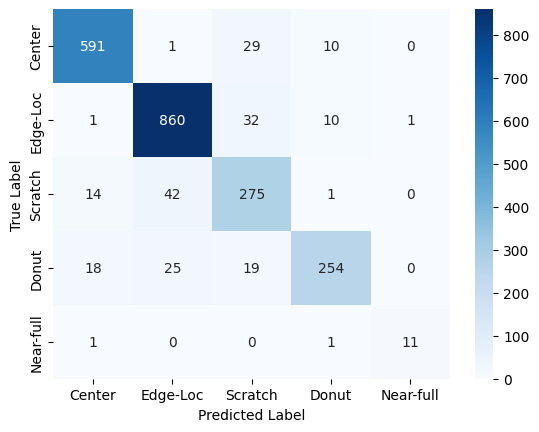

In [ ]:
# TODO: get the predicted labels of the training data and calculate the accuracy
pred_train = svc_classifier.predict(X_train)
acc_train = calculate_accuracy(pred_train, y_train) * 100
print(f'Model accuracy on training data set is {acc_train:.2f}%')

# TODO: calculate the accuracy for each failure type
accuracies_train = calculate_per_class_accuracy(pred_train, y_train)
print(f'Model accuracy on training data set for each class is {accuracies_train}')

# TODO: get failure types string sorted by their numerical value
# that is, the strings like 'Center' and 'Scratch' sorted by the ints assigned to them.
tick_labels = [int2String[i] for i in sorted(int2String.keys())]

# TODO: compute the confusion matrix
cm = confusion_matrix(y_train, pred_train)

# plot confusion matrix using heatmap
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=tick_labels, 
            yticklabels=tick_labels,
            cmap='Blues')

# TODO: provide x-axis label and y-axis labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# show plot
plt.show()


Model accuracy on validation data set is 0.91%
Model accuracy on validation data set for each class is {'Center': 0.9142857142857143, 'Edge-Loc': 0.9490196078431372, 'Scratch': 0.8518518518518519, 'Donut': 0.875, 'Near-full': 0.5}%


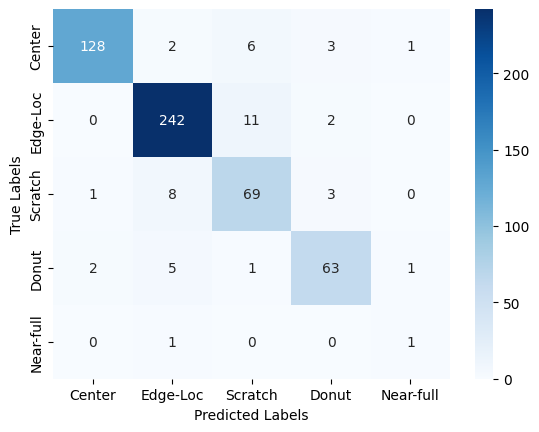

In [ ]:
# TODO: get the predicted labels of the validation data and calculate the accuracy
pred_valid = dt_classifier.predict(X_valid)
acc_valid = calculate_accuracy(pred_valid, y_valid)
print(f'Model accuracy on validation data set is {acc_valid:.2f}%')

# TODO: calculate the accuracy for each failure type
accuracies_valid = calculate_per_class_accuracy(pred_valid, y_valid)
print(f'Model accuracy on validation data set for each class is {accuracies_valid}%')

# TODO: get failure types string sorted by their numerical value
# that is, the strings like 'Center' and 'Scratch' sorted by the ints
# assigned to them.
tick_labels = [int2String[i] for i in sorted(int2String.keys())]

# TODO: compute confusion matrix
cm = (
    confusion_matrix(y_valid, pred_valid)
)

# plot confusion matrix using heatmap
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=tick_labels, 
            yticklabels=tick_labels,
            cmap='Blues')

# TODO: provide x-axis label and y-axis label
plt.xlabel('Predicted Labels')
plt.ylabel(' True Labels')

# show plot
plt.show()

Model accuracy on validation data set is 91.45%
Model accuracy on validation data set for each class is {'Center': 0.8928571428571429, 'Edge-Loc': 0.9607843137254902, 'Scratch': 0.8518518518518519, 'Donut': 0.8611111111111112, 'Near-full': 1.0}


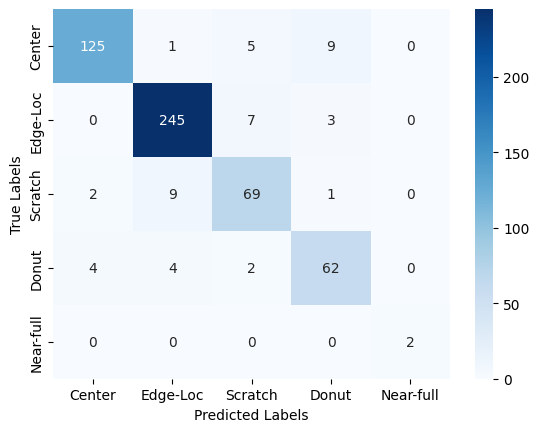

In [139]:
# TODO: get the predicted labels of the validation data and calculate the accuracy
pred_valid = svc_classifier.predict(X_valid)
acc_valid = calculate_accuracy(pred_valid, y_valid) * 100
print(f'Model accuracy on validation data set is {acc_valid:.2f}%')

# TODO: calculate the accuracy for each failure type
accuracies_valid = calculate_per_class_accuracy(pred_valid, y_valid)
print(f'Model accuracy on validation data set for each class is {accuracies_valid}')

# TODO: get failure types string sorted by their numerical value
# that is, the strings like 'Center' and 'Scratch' sorted by the ints assigned to them.
tick_labels = [int2String[i] for i in sorted(int2String.keys())]

# TODO: compute confusion matrix
cm = confusion_matrix(y_valid, pred_valid)

# plot confusion matrix using heatmap
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=tick_labels, 
            yticklabels=tick_labels,
            cmap='Blues')

# TODO: provide x-axis label and y-axis label
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# show plot
plt.show()


Index(['areaRatio', 'perimeterRatio', 'maxDistFromCenter', 'minDistFromCenter',
       'majorAxisRatio', 'minorAxisRatio', 'solidity', 'eccentricity',
       'yieldLoss', 'edgeYieldLoss'],
      dtype='object')


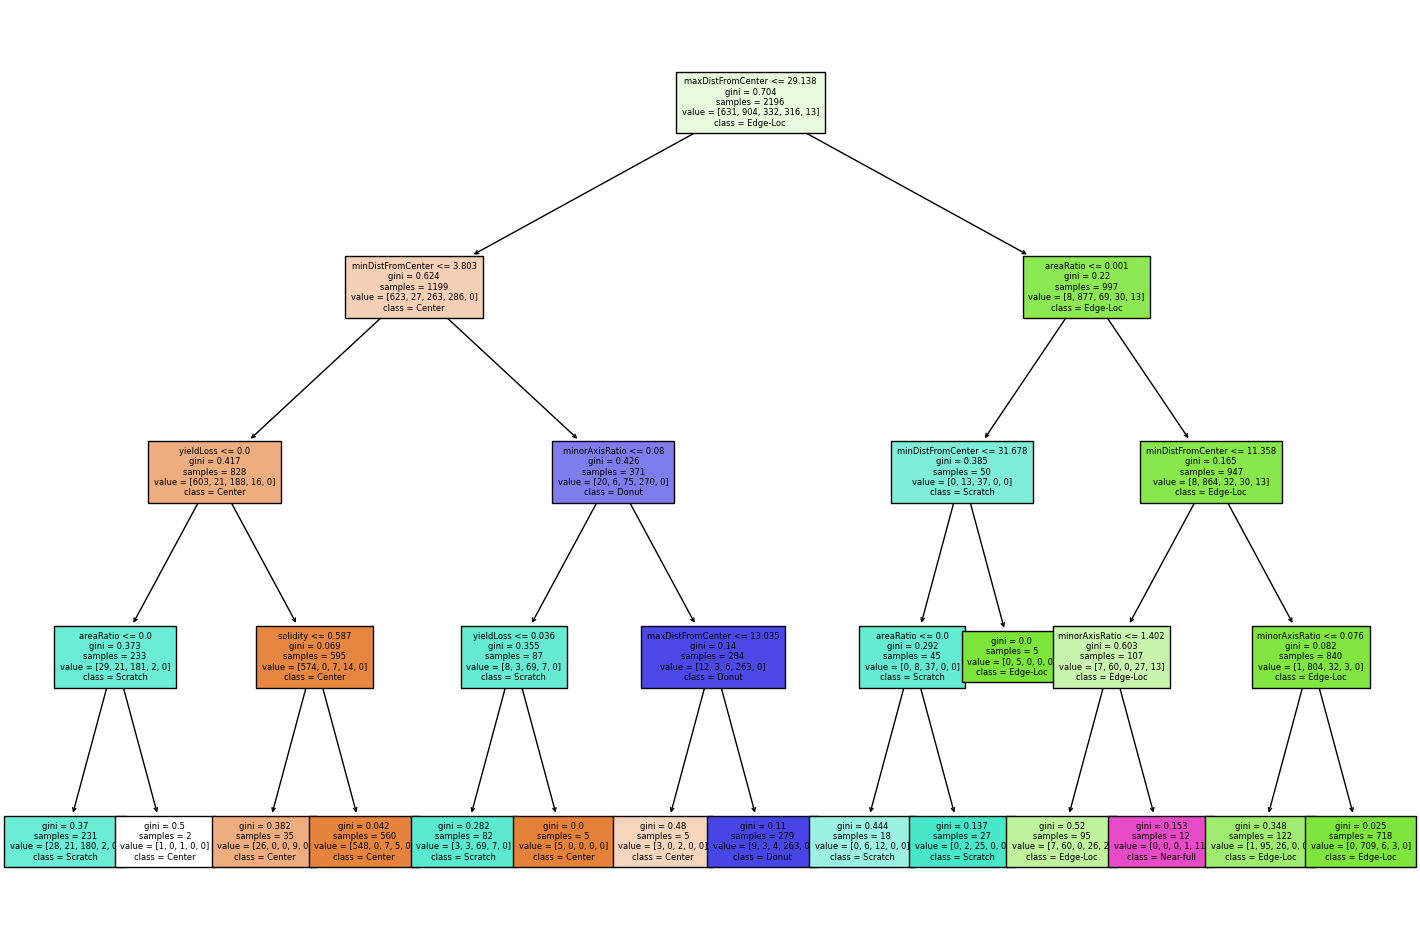

In [140]:
# TODO: get failure types string sorted by their numerical value
# that is, the strings like 'Center' and 'Scratch' sorted by the ints
# assigned to them.
tick_labels = [int2String[i] for i in sorted(int2String.keys())]

print(selected_features)

# plot decision tree
if isinstance(dt_classifier, tree.DecisionTreeClassifier):
    plt.figure(figsize=(18,12))
    tree.plot_tree(
        dt_classifier,                     # classifier to extract the rules from
        feature_names=selected_features, # the feature names that were used
        class_names=tick_labels,        # the class labels, converted to string
        filled=True, fontsize=6
    )
    plt.show()

### Testing Set

Data Loading, Preprocess, and Feature Extraction

In [141]:
# TODO: load test dataset with pandas from wafermap_test.npy
test_data = np.load('./data/wafermap_test.npy', allow_pickle=True)
df_test = pd.DataFrame(test_data)


# TODO: apply data preparation function
# note: test data does not have failureType column
df_test_prepared = prepare_data(df_test, has_labels=False)

# TODO: apply feature exatractors to extract features
df_test_features = create_feature_columns(df_test_prepared)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2026 entries, 0 to 2025
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dieSize            2026 non-null   float64
 1   lotName            2026 non-null   object 
 2   trainTestLabel     2026 non-null   object 
 3   waferIndex         2026 non-null   float64
 4   waferMap           2026 non-null   object 
 5   salientRegion      2026 non-null   object 
 6   areaRatio          2026 non-null   float64
 7   perimeterRatio     2026 non-null   float64
 8   maxDistFromCenter  2026 non-null   float64
 9   minDistFromCenter  2026 non-null   float64
 10  majorAxisRatio     2026 non-null   float64
 11  minorAxisRatio     2026 non-null   float64
 12  solidity           2026 non-null   float64
 13  eccentricity       2026 non-null   float64
 14  yieldLoss          2026 non-null   float64
 15  edgeYieldLoss      2026 non-null   int64  
dtypes: float64(11), int64(1)

Generate Predictions for the Test Set

In [142]:
# TODO: From the dataframe select the features we extracted as X 
# and y is the numerical failure type labels
X_test = df_test_features[selected_features]
# TODO: get the predicted labels of the test data,
# convert them back to strings,
# and output as `scores.csv`.
pred_test = dt_classifier.predict(X_test)
pred_test_labels = [int2String[label] for label in pred_test]

# Create a DataFrame for the output
output_df = pd.DataFrame(pred_test_labels, columns=['failureType'])

# Save to CSV
output_df.to_csv('dt_scores.csv', index=False)


In [143]:
# TODO: From the dataframe select the features we extracted as X 
# and y is the numerical failure type labels
X_test = df_test_features[selected_features]
# TODO: get the predicted labels of the test data,
# convert them back to strings,
# and output as `scores.csv`.
pred_test = svc_classifier.predict(X_test)
pred_test_labels = [int2String[label] for label in pred_test]



# Create a DataFrame for the output
output_df = pd.DataFrame(pred_test_labels, columns=['failureType'])

# Save to CSV
output_df.to_csv('svc_scores.csv', index=False)
